<a href="https://www.kaggle.com/code/antobenedetti/finance-news-sentiments-classifier?scriptVersionId=226144643" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This notebook is still under development. The model is overfitting. I'm learning how to fix that. I've already tried to increase the dataset size but it didn't work out.

If you have any suggestions, please post them in the comment section.

In [2]:
import pandas as pd
from pandas import DataFrame

dataset_path: str = "/kaggle/input/finance-news-sentiments/dataset.csv"
df: DataFrame = pd.read_csv(
    dataset_path,
    header=0
)
df = df.astype(str)
df.sample(5)

,sentiment,text
29640,positive,China’s antitrust authority has suspended a pr...
14715,negative,Merck to Bristol-Myers Face More Threats on In...
19121,neutral,Kenya’s central bank lowers interest rates for...
32409,neutral,LIVE: U.S. attorney general and FBI deputy dir...
29304,negative,"""Islam is the light"" doll--SHARIAH LAW DOLL ma..."


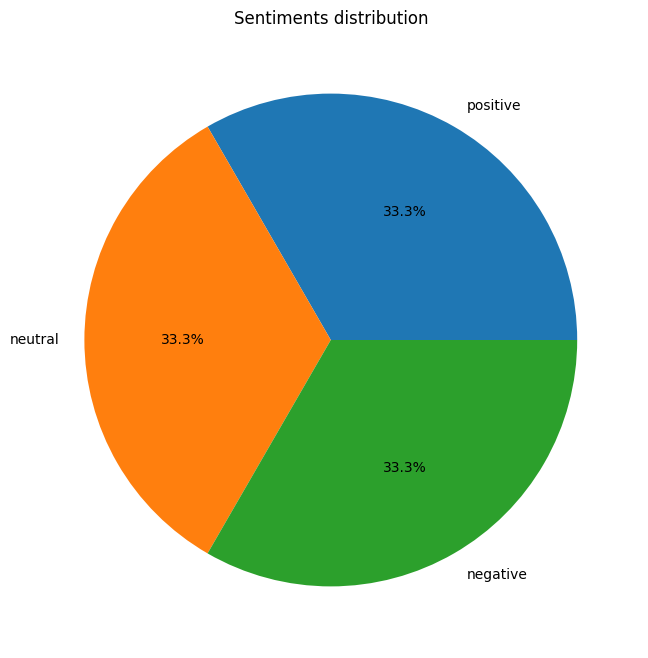

In [3]:
import matplotlib.pyplot as plt
from pandas import Series

label_counts: Series = df.sentiment.value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Sentiments distribution')
plt.show()

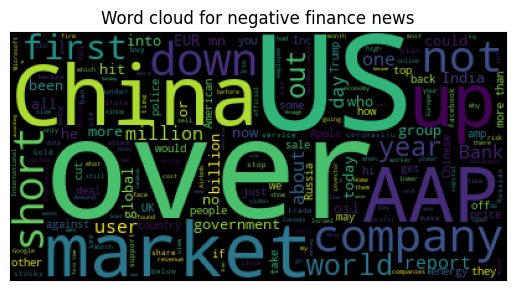

In [4]:
# Word cloud
from wordcloud import WordCloud

# Don't display common words of either class
stopwords: list[str] = [
    "new", "will", "stock", "to", "in", "and", "the", "for", "an", "be",
    "of", "on", "a", "it", "i", "as", "is", "by", "with", "has", "but",
    "that", "from", "after", "at", "its", "say", "ha", "are", "wa", "u",
    "here", "this", "have", "their", "said", "says", "was", "thi", "s"
]

text: str = " ".join(df[df.sentiment == "negative"].text)
word_cloud = WordCloud(stopwords=stopwords).generate(text)
plt.title("Word cloud for negative finance news")
plt.xticks([])  
plt.yticks([])
plt.imshow(word_cloud)

In [ ]:
text: str = " ".join(df[df.sentiment == "neutral"].text)
word_cloud = WordCloud(stopwords=stopwords).generate(text)
plt.title("Word cloud for neutral finance news")
plt.xticks([])  
plt.yticks([])
plt.imshow(word_cloud)

In [ ]:
text: str = " ".join(df[df.sentiment == "positive"].text)
word_cloud = WordCloud(stopwords=stopwords).generate(text)
plt.title("Word cloud for positive finance news")
plt.xticks([])  
plt.yticks([])
plt.imshow(word_cloud)

In [ ]:
# Get the number of unique words in all the texts
def get_vocab_size(strings: Series) -> int:
    unique_words: set[str] = set()
    for string in strings:
        for word in string.split():
            unique_words.add(word)
    return len(unique_words)


vocab_size: int = get_vocab_size(df.text.squeeze())
print(f"Vocabulary size: {vocab_size}")

In [ ]:
from transformers import TFAutoModel, AutoTokenizer

model = TFAutoModel.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
def tokenize(batch):
    if isinstance(batch["text"], list):
        batch["text"] = [str(text) for text in batch["text"]]
    else:
        batch["text"] = str(batch["text"])
        
    return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
from datasets import Dataset, DatasetDict

### Encode labels from string to integer
df.sentiment = df.sentiment.map({
    'negative': 0,
    'neutral' : 1,
    'positive': 2
})

df_train = df.iloc[6000:, :]
df_val = df.iloc[:3000, :]
df_test = df.iloc[3000:6000, :]

train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)

dataset = DatasetDict()
dataset["train"] = train_dataset
dataset["validation"] = val_dataset
dataset["test"] = test_dataset

encoded_dataset = dataset.map(tokenize, batched=True, batch_size=None)
encoded_dataset

In [ ]:
import tensorflow as tf

# setting 'input_ids', 'attention_mask', 'token_type_ids', and 'label'
# to the tensorflow format. Now if you access this dataset you will get these
# columns in `tf.Tensor` format

encoded_dataset.set_format(
    'tf', 
    columns=['input_ids', 'attention_mask', 'token_type_ids', 'sentiment']
)

# setting BATCH_SIZE to 64.
BATCH_SIZE = 64

def order(inputs):
    '''
    This function will group all the inputs of BERT
    into a single dictionary and then output it with
    labels.
    '''
    data = list(inputs.values())
    return {
        'input_ids': data[1],
        'attention_mask': data[2],
        'token_type_ids': data[3]
    }, data[0]

# converting train split of `emotions_encoded` to tensorflow format
train_dataset = tf.data.Dataset.from_tensor_slices(encoded_dataset['train'][:])
# set batch_size and shuffle
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(1000)
# map the `order` function
train_dataset = train_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(encoded_dataset['validation'][:])
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(encoded_dataset['test'][:])
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE) 

In [ ]:
class BERTForClassification(tf.keras.Model):
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
        
    def call(self, inputs):
        x = self.bert(inputs)[1]
        return self.output_layer(x)

In [ ]:
model = BERTForClassification(model, num_classes=3)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=8
)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_dataset)

In [ ]:
model.save("model.h5")